In this project, we will be scraping crypto currency data, Analyzing the data, and building visualizations that shows the main insights about the crypto currency market.


The cryptocurrency market is a dynamic and decentralized financial ecosystem that consists of various digital assets, commonly known as cryptocurrencies. Operating on blockchain technology, these digital currencies provide individuals and institutions with an alternative means of transferring value, conducting transactions, and potentially serving as a store of value, outside the traditional financial system. The market's growth and innovation continue to shape the landscape of modern finance, attracting both investors and enthusiasts alike.

# Data Scraping

We will be scrapping the data from "coinmarketcap.com". The website has data for more than 10,000 crypto currencies.

For scrapping the data, we will be using the BeautifulSoup library and selenium library for simulating the scrolling of the page.

We will be scraping the following data about the crypto currency:
- Name
- Abbreviation
- Price
- URL of the currency page on the website
- Circulating Supply (The amount of coins that are circulating in the market and are in public hands)
- Market Cap (The total market value of a cryptocurrency's circulating supply)
- Volume (A measure of how much of a cryptocurrency was traded in the last 24 hours)

In [1]:
import requests
from bs4 import BeautifulSoup
import json

BASE_URL = 'https://coinmarketcap.com'

# Get the data from the url using BeautifulSoup
response = requests.get(BASE_URL)
soup = BeautifulSoup(response.text, 'html.parser')

In [2]:
# Get the table from the soup
table = soup.find('table', {'class': 'sc-996d6db8-3 cOXNvh cmc-table'})

table_head = table.thead
table_body = table.tbody

print(repr(table)[:500])

<table class="sc-996d6db8-3 cOXNvh cmc-table"><colgroup><col/><col style="width:50px;min-width:auto;max-width:auto"/><col style="width:250px;min-width:auto;max-width:auto"/><col/><col style="width:84px;min-width:auto;max-width:auto"/><col style="width:84px;min-width:auto;max-width:auto"/><col style="width:84px;min-width:auto;max-width:auto"/><col style="width:200px;min-width:auto;max-width:auto"/><col style="width:200px;min-width:auto;max-width:auto"/><col style="width:200px;min-width:auto;max-w


In [3]:
# Getting the table rows
rows = table_body.find_all('tr')


# Extracting the main features from the first raw as a demo
first_row = rows[0]

cur_name = first_row.find('p', {'class': 'sc-4984dd93-0 kKpPOn'}).text
cur_abbreviation = first_row.find('p', {'class': 'sc-4984dd93-0 iqdbQL coin-item-symbol'}).text
cur_price = first_row.find_all('a', {'class': 'cmc-link'})[1].span.text
cur_url = BASE_URL + first_row.find('a', {'class': 'cmc-link'})['href']
cur_market_cap = first_row.find('span', {'class': 'sc-f8982b1f-1 bOsKfy'}).text
cur_volume = first_row.find('p', {'class': 'sc-4984dd93-0 jZrMxO font_weight_500'}).text
cur_circulating_supply = first_row.find('p', {'class': 'sc-4984dd93-0 WfVLk'}).text


print("Name : ", cur_name, ", Abbreviation : ", cur_abbreviation, ", URL: ", cur_url)
print("Price: ", cur_price, ", Market Cap: ", cur_market_cap, ", Volume: ", cur_volume)
print("Circulating Supply: ", cur_circulating_supply)

Name :  Bitcoin , Abbreviation :  BTC , URL:  https://coinmarketcap.com/currencies/bitcoin/
Price:  $29,928.92 , Market Cap:  $581,554,761,939 , Volume:  $12,756,373,806
Circulating Supply:  19,432,006 BTC


Now, we will make a loop that apply the same steps we followed above to collect the data from the all the pages in the site. We will use selenium library to scroll to the bottom of the page as the website has only the first 10 rows in the page loaded initially

In [4]:
import time
from selenium import webdriver
from selenium.webdriver.common.by import By

data = []

# Create a WebDriver instance (using Chrome here)
driver = webdriver.Chrome()

try:
    for i in range(1,103):
        # URL for the page
        url = BASE_URL + '/?page=' + str(i)
        
        # Load the page with WebDriver
        driver.get(url)
        
        # Use JavaScript to smoothly scroll the page down
        scroll_height = 0
        while True:
            driver.execute_script(f"window.scrollTo(0, {scroll_height});")
            scroll_height += 250  # Adjust the scrolling speed here
            time.sleep(0.1)  # Adjust this delay to control scrolling speed
            
            if scroll_height >= driver.execute_script("return document.body.scrollHeight;"):
                break
        
        # Wait for the page to load completely
        time.sleep(3)
        
        # Get the page source after the content is loaded
        page_source = driver.page_source
        
        # Using BeautifulSoup to parse the data
        soup = BeautifulSoup(page_source, 'html.parser')

        table = soup.find('table', {'class': 'sc-996d6db8-3 cOXNvh cmc-table'})
        table_body = table.tbody
        rows = table_body.find_all('tr')

        for row in rows:            
            cur_name = row.find('p', {'class': 'sc-4984dd93-0 kKpPOn'})
            cur_abbreviation = row.find('p', {'class': 'sc-4984dd93-0 iqdbQL coin-item-symbol'})
            
            # Add a check for at least two elements in the list before accessing index [1]
            cmc_links = row.find_all('a', {'class': 'cmc-link'})
            cur_price = cmc_links[1].span.text if len(cmc_links) >= 2 else None
            
            cur_url = BASE_URL + row.find('a', {'class': 'cmc-link'})['href']
            cur_market_cap = row.find('span', {'class': 'sc-f8982b1f-1 bOsKfy'})
            cur_volume = row.find('p', {'class': 'sc-4984dd93-0 jZrMxO font_weight_500'})
            cur_circulating_supply = row.find('p', {'class': 'sc-4984dd93-0 WfVLk'})

            # Convert None values to appropriate representations
            cur_name = cur_name.text if cur_name else None
            cur_abbreviation = cur_abbreviation.text if cur_abbreviation else None
            cur_market_cap = cur_market_cap.text if cur_market_cap else None
            cur_volume = cur_volume.text if cur_volume else None
            cur_circulating_supply = cur_circulating_supply.text if cur_circulating_supply else None

            data.append({
                'name': cur_name,
                'abbreviation': cur_abbreviation,
                'price': cur_price,
                'url': cur_url,
                'market_cap': cur_market_cap,
                'volume': cur_volume,
                'circulating_supply': cur_circulating_supply,
            })
finally:
    # Close the WebDriver instance once scraping is done
    driver.quit()

In [5]:
# Saving the scraped data in a json file
file_path = 'data/data.json'

with open(file_path, 'w') as json_file:
    json.dump(data, json_file)

# Data Cleaning and Exploration

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_json('data/data.json')
df.head()

,name,abbreviation,price,url,market_cap,volume,circulating_supply
0,Bitcoin,BTC,"$29,929.63",https://coinmarketcap.com/currencies/bitcoin/,"$581,750,193,516","$12,756,373,806","19,432,006 BTC"
1,Ethereum,ETH,"$1,890.97",https://coinmarketcap.com/currencies/ethereum/,"$227,358,711,713","$6,463,158,931","120,201,013 ETH"
2,Tether,USDT,$1.00,https://coinmarketcap.com/currencies/tether/,"$83,670,920,745","$23,972,325,909","83,649,374,840 USDT"
3,XRP,XRP,$0.7336,https://coinmarketcap.com/currencies/xrp/,"$38,538,940,285","$2,649,601,208","52,544,091,958 XRP"
4,BNB,BNB,$242.71,https://coinmarketcap.com/currencies/bnb/,"$37,795,939,912","$683,850,105","155,848,531 BNB"


In [3]:
# Converting 'Price', 'Circulating Supply', 'Market Cap', and 'Volume' columns to numeric types
df['price'] = pd.to_numeric(df['price'].str.replace('[^0-9.]', '', regex=True), errors='coerce')
df['circulating_supply'] = pd.to_numeric(df['circulating_supply'].str.replace('[^0-9.]', '', regex=True), errors='coerce')
df['market_cap'] = pd.to_numeric(df['market_cap'].str.replace('[^0-9.]', '', regex=True), errors='coerce')
df['volume'] = pd.to_numeric(df['volume'].str.replace('[^0-9.]', '', regex=True), errors='coerce')


In [4]:
# Printing the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10114 entries, 0 to 10113
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                10114 non-null  object 
 1   abbreviation        10114 non-null  object 
 2   price               8558 non-null   float64
 3   url                 10114 non-null  object 
 4   market_cap          7416 non-null   float64
 5   volume              8034 non-null   float64
 6   circulating_supply  4415 non-null   float64
dtypes: float64(4), object(3)
memory usage: 553.2+ KB


In [5]:
# Getting a random sample from the names of currencies which their rows have missing values
df[df.isnull().any(axis=1)].sample(15)['name'].values

array(['Artemis Protocol', 'CryptoMines Reborn', 'Token', 'BITCOLOJIX',
       'Kokoswap', 'Hello Pets', 'Changer', 'Nanomatic',
       'Frz Solar System', 'Uniwhale', 'LunaChow', 'World ID',
       'Dopex Rebate Token', 'OneRoot Network', 'Sloth'], dtype=object)

After researching some of the currencies which have null values in their rows, we found that most of these currencies are very unpopular and cheap currencies. The prices of these currencies are  very close to 0 and their market cap, volume, and circulating supply are very low. For this reason, we believe that we can safely fill these null values with 0.

In [6]:
# Filling the missing values with 0 for the circulating_supply, market_cap, price and volume columns
df['circulating_supply'].fillna(0, inplace=True)
df['market_cap'].fillna(0, inplace=True)
df['price'].fillna(0, inplace=True)
df['volume'].fillna(0, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10114 entries, 0 to 10113
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                10114 non-null  object 
 1   abbreviation        10114 non-null  object 
 2   price               10114 non-null  float64
 3   url                 10114 non-null  object 
 4   market_cap          10114 non-null  float64
 5   volume              10114 non-null  float64
 6   circulating_supply  10114 non-null  float64
dtypes: float64(4), object(3)
memory usage: 553.2+ KB


In [8]:
# Check if there is any duplicate rows
df.duplicated().sum()

6

In [9]:
# Drop the duplicate rows
df.drop_duplicates(inplace=True)

In [10]:
df.duplicated().sum()

0

# Visualizations

### Price of the Top 5 Ranked cryptocurrencies.

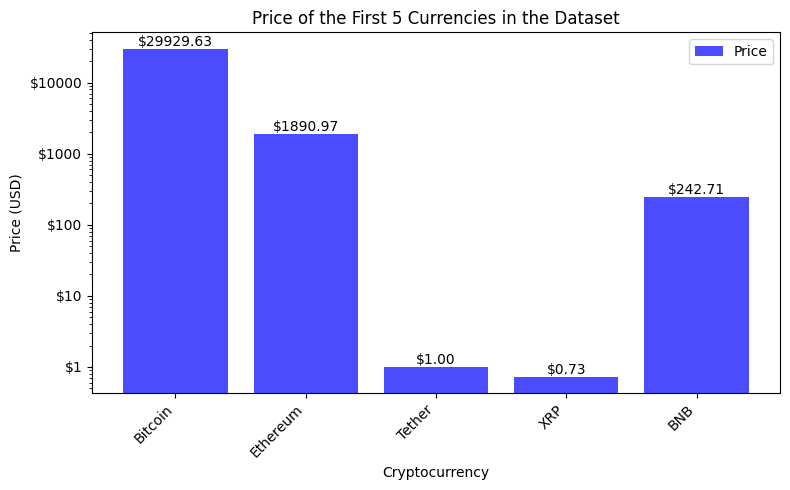

In [11]:
import matplotlib.ticker as ticker

top_5_currencies = df[:5]

# Create a bar chart to visualize the prices of the first 5 currencies
plt.figure(figsize=(8, 5))
bars = plt.bar(top_5_currencies['name'], top_5_currencies['price'], color='b', alpha=0.7)

# Add text annotations for each currency's price
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"${height:.2f}", ha='center', va='bottom', fontsize=10)

plt.xlabel('Cryptocurrency')
plt.ylabel('Price (USD)')
plt.title('Price of the First 5 Currencies in the Dataset')
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.legend(['Price'], loc='upper right')

# Customize the y-axis tick labels
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '${}'.format(int(y))))

plt.tight_layout()
plt.show()

### Volume of the Top 5 Ranked cryptocurrencies

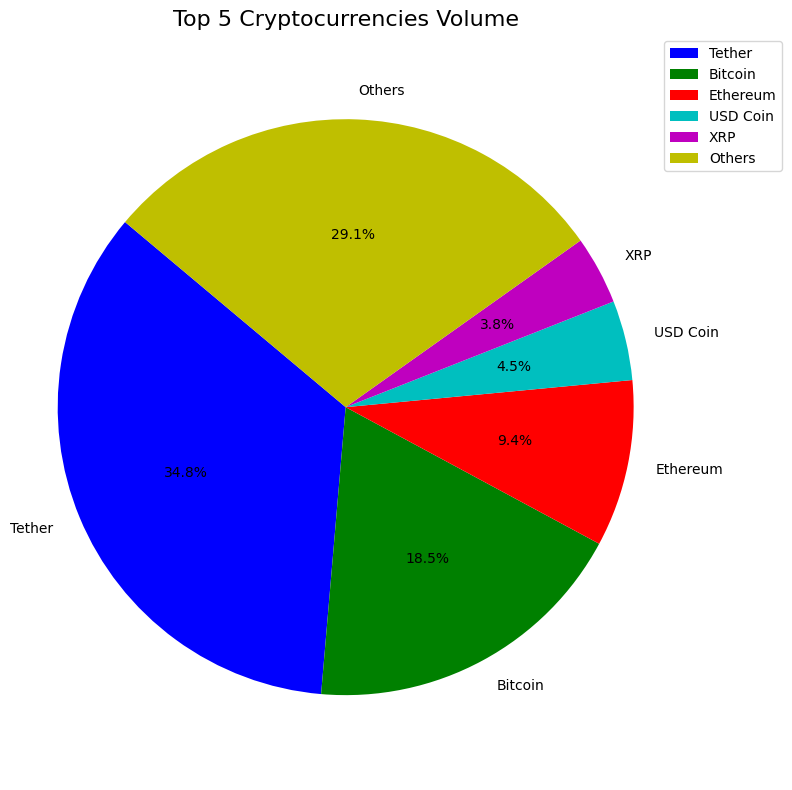

In [12]:
# Calculate the total volume of all cryptocurrencies
total_volume = df['volume'].sum()

# Select the top 5 cryptocurrencies by volume
top_5_currencies = df.nlargest(5, 'volume')

# Calculate the total volume of other cryptocurrencies (excluding the top 5)
other_volume = total_volume - top_5_currencies['volume'].sum()

# Create a DataFrame for the "Others" category
others_data = pd.DataFrame({'name': ['Others'], 'volume': [other_volume]})

# Concatenate the top 5 and "Others" DataFrames
pie_data = pd.concat([top_5_currencies, others_data], ignore_index=True)

# Create a pie chart to visualize the volumes
plt.figure(figsize=(8, 8))
plt.pie(pie_data['volume'], labels=pie_data['name'], autopct='%1.1f%%', startangle=140, colors=['b', 'g', 'r', 'c', 'm', 'y'])
plt.title('Top 5 Cryptocurrencies Volume', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()

From the previous graph, we can see that although we have more than 10,000 crypto currencies in our dataset, the top 5 ranked crypto currencies are representing around 70% in terms of the volume. This means that the top 5 ranked crypto currencies are the most popular currencies in the market and they are the most traded currencies in the market.

### The Most Expensive Cryptocurrencies

<AxesSubplot: title={'center': 'Top 10 Cryptocurrencies by Price'}, xlabel='Price', ylabel='Cryptocurrency Name'>

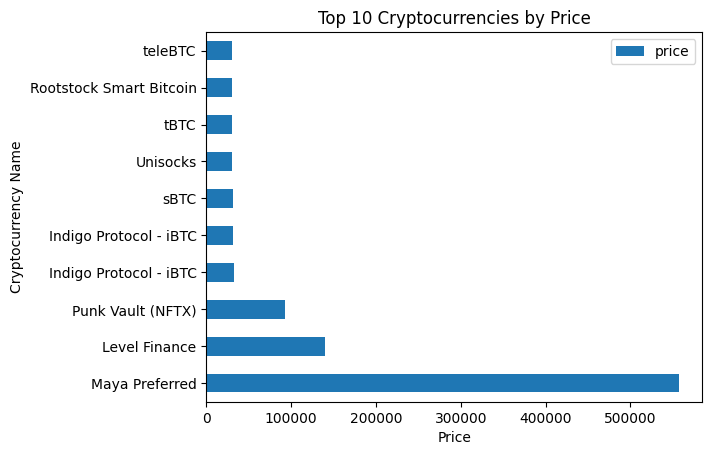

In [14]:
# Plot the top 10 cryptocurrencies by price
top_10_by_price = df.sort_values(by='price', ascending=False).head(10)
top_10_by_price.plot(x='name', y='price', kind='barh', title='Top 10 Cryptocurrencies by Price',
                  xlabel='Price', ylabel='Cryptocurrency Name')

From the previous graph, we can see the most expensive Cryptocurrency in the market is Maya preferred which is worth more than 500,000 dollars. After it comes Level Finance and Punk Vault.